## Sample tweets for hand-labeling based on classification scores

Uses classifiers trained on labeled tweets (about a myth vs. not) to filter tweets from March to August 2020 (especially April-May) to only those with a higher probability of being in the minority class than the majority class. This will be used to select tweets for hand-coding that fall into minority classes, which are hard to capture from the first round of ML models. Data source is tweets with hashtags related to Covid-19.

Usage: `python3 6_filter_tweets.py -{myth prefix} {directory of classifier} {directory of vectorizer} -t {threshold lower bound} {threshold upper bound, < not <=} -nrand {number of files sampled from} -nrows {number of rows browsed in each file}`

## Initialize

### Import libraries

In [2]:
import sys
import pandas as pd
import numpy as np
import re, csv, os
from datetime import date
from random import sample
from collections import Counter
import gcsfs # for quick loading of data from gcloud
from tqdm import tqdm
tqdm.pandas()
import time
import emoji
import math

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
import joblib
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Custom function for loading data
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from shared.utils import gcs_read_json_gz

### Define filepaths

In [3]:
bucket_fp = 'gs://COVID_TWEETS_DIR/'

# paths for ML model and vectorizer
fvg_mod_fp = '../models/tweet_classifier_5G_DT_020422.joblib'
fvg_vec_fp = '../models/vectorizer_5G_020422.joblib'

n_sample = 180
thisday = date.today().strftime("%d%m%y")

# output path for sample
fvg_sam_fp = f'../data/myth_5G_sample_{str(n_sample)}_{str(thisday)}.csv'

In [4]:
def read_tweets (dirname, 
                 num_rand_files = 0, 
                 start_week_num = -1, 
                 end_week_num = 0, 
                 levels = 1, 
                 nrows = 50, 
                 previous_tweets = [],
                 language = 'en'):
    
    """
    Read latest Twitter data from JSON files. 
    Options: take random number of files from each folder, 
    look only at folders for weeks within specified range, and/or 
    read files in single folder (1 level) or folder of folders (2 levels).
    
    Args:
        dirname: folder in Google Cloud Compute Server where Twitter JSON files live
        num_rand_files: number of random files to draw from each folder. Useful when randomly sampling from files with lots of tweets
        start_week_num: first week in range (to take tweets from), inclusive
        end_week_num: last week in range (to take tweets from), inclusive
        levels: number of folders in hierarchy ('dirname/file1, dirname/file2, etc.' = one level)
        nrows: number of tweets to read from file
        previous_tweets: list of previous samples to remove duplicate tweets
        language: filter to only tweets in this language
    Returns:
        df: DataFrame with loaded in Twitter data
    """
    
    fs = gcsfs.GCSFileSystem(project="PROJECT", token="cloud")
    
    if levels == 2: # two levels (multiple folders)
        files = []
        folders = [folder for folder in fs.ls(dirname) 
                   if folder != dirname 
                   and os.path.join("gs://", folder) != dirname] # don't keep duplicate folders = same as dirname
        
        for folder in folders:
            # only process folders where: start_week_num < week_number < end_week_num
            week_num = int(folder.split('/')[-1][9:]) # get week number: last part of file path, anything after '2020-week'
            if week_num < start_week_num or (end_week_num > 0 and week_num > end_week_num):
                continue # skip if not in week range
            
            # for folders of weeks in desired range, get their files
            listf = fs.ls(os.path.join("gs://", folder)) # get list of files in this folder
            listf = [re.sub(r"#", r"%23", file) for file in listf] # in each file name, replace '#' with '%23' so pandas can read it
            if num_rand_files > 0:
                listf = sample(listf, num_rand_files) # get specified number of random files
            files.extend(listf) # add each file to list
            files = [x for x in files if x.endswith(".json") or x.endswith(".json.gz")]
            
    else: # one level (just one folder)
        files = fs.ls(dirname)
        files = [x for x in files if x.endswith(".json") or x.endswith(".json.gz")]
        if num_rand_files > 0:
            files = sample(listf, num_rand_files) # get specified number of random files
    
    print(dirname)
    files = [x.replace("%23", "#") for x in files]
    print(files)
    
    print(f"Reading in tweets from {len(files)} JSON files...")
    
    # Load and merge files as DFs
    dfs = []
    for f in tqdm(files):
        #print("gs://{}".format(f))
        # thisdf = pd.read_json("gs://{}".format(f), nrows = nrows, lines=True, compression = 'gzip')
        thisdf = gcs_read_json_gz("gs://{}".format(f), nrows=nrows)
        if 'lang' in thisdf.columns:
            thisdf['language'] = thisdf['lang'] # funnel 'lang' to 'language' column
            thisdf.drop(columns = 'lang', inplace = True) # erase 'lang' column (now a duplicate)
        thisdf = thisdf[(thisdf['language'] == 'null') | (thisdf['language']==language)] # Filter to only tweets in language
        dfs.append(thisdf)
    df = pd.concat(dfs, ignore_index = True)
    df['id'] = df['id'].astype(str)
    
    # Remove duplicate tweets
    for id in previous_tweets:
        df = df[df['id'] != id] 
    
    return df

## Load & inspect data

In [5]:
# Load ML model(s) for classifying myths
fvg_mod = joblib.load(fvg_mod_fp)

# Load vectorizer(s) to keep vocab consistent with training data
fvg_vec = joblib.load(fvg_vec_fp)

In [7]:
# Load previous samples for duplicate check

previous_fp = ['../data/samples/5G/myth_5G_sample_130.csv',
               '../data/samples/5G/myth_5G_sample_135.csv'
              ]
previous_dfs = []
for fp in previous_fp:
    previous_dfs.append(pd.read_csv(fp, names=['id']))
previous_ids = pd.concat(previous_dfs, ignore_index = True)
previous_ids

,id
0,full_text
1,PEOPLE! 5G DOES NOT have anything to do with #...
2,Tune into the #IUIC 6Pm est #Sabbath Class tod...
3,I see a number of Cell Towers/phone masts have...
4,Tune into the #IUIC 6Pm est #Sabbath Class tod...
...,...
262,rt @crackedscience to implicate 5g cell phone ...
263,rt @ianyorston police took piers corbyn away i...
264,rt @sonsocmed do people really believe the 5g ...
265,rt @mazinnamdikanu as leaders across the globe...


## Sample Tweets

### Load and inspect the data

In [9]:
# April - May
df = read_tweets(bucket_fp, 
                 num_rand_files = 1, 
                 start_week_num = 14, 
                 end_week_num = 22, 
                 levels = 2, 
                 nrows = 5000,
                 previous_tweets = previous_ids,
                 language='en')

print('Number of rows (tweets) and cols in DF:', str(df.shape))
print()
print('Columns in tweets DF:\n', str(df.columns))
print()

# See examples of two tweets. 
# Have usernames and URLs already been replaced?
print("Example tweet 1:\n", df['full_text'].iloc[0])
print()
print("Example tweet 2:\n", df['full_text'].iloc[10])
print()

df.head(5)

  0%|          | 0/18 [00:00<?, ?it/s]

gs://project_coronavirus/raw/hashtag/
['project_coronavirus/raw/hashtag/2020-week14/#武漢肺炎疫情_20200405.json.gz', 'project_coronavirus/raw/hashtag/2020-week15/#WuhanCoronavirus_20200409.json.gz', 'project_coronavirus/raw/hashtag/2020-week16/#SARI_20200419.json.gz', 'project_coronavirus/raw/hashtag/2020-week17/#武漢_20200422.json.gz', 'project_coronavirus/raw/hashtag/2020-week18/#武汉_20200502.json.gz', 'project_coronavirus/raw/hashtag/2020-week19/#2019nCoV_20200510.json.gz', 'project_coronavirus/raw/hashtag/2020-week20/#2019nCoV_20200519.json.gz', 'project_coronavirus/raw/hashtag/2020-week21/#coronavirusoutbreak_20200529.json.gz', 'project_coronavirus/raw/hashtag/2020-week22/twint_#Covid_19_20200525.json.gz', 'project_coronavirus/raw/hashtag/2021-week14/#corona_20210409.json.gz', 'project_coronavirus/raw/hashtag/2021-week15/#WuhanCoronavirus_20210414.json.gz', 'project_coronavirus/raw/hashtag/2021-week16/#2019nCoV_20210424.json.gz', 'project_coronavirus/raw/hashtag/2021-week17/#viruschina_202

100%|██████████| 18/18 [00:13<00:00,  1.29it/s]

Number of rows (tweets) and cols in DF: (9531, 62)

Columns in tweets DF:
 Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'metadata',
       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'retweeted_status', 'is_quote_status', 'retweet_count',
       'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive',
       'language', 'quoted_status_id', 'quoted_status_id_str', 'quoted_status',
       'withheld_in_countries', 'conversation_id', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'tweet', 'mentions', 'urls', 'photos',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'thumbnail',
       'near', 'user_rt_id', 'user_rt', 'retweet_id', 're

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,metadata,source,...,thumbnail,near,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,2020-04-09 23:59:28+00:00,1248400168547831811,1.248400e+18,RT @RealJamesWoods: This could indicate that t...,False,"[0, 140]","{'hashtags': [{'text': 'WuhanCoronaVirus', 'in...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-04-09 23:59:12+00:00,1248400097391468545,1.248400e+18,@globaltimesnews Did they test for any local c...,False,"[17, 157]","{'hashtags': [{'text': 'WuhanCoronaVirus', 'in...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-04-09 23:59:06+00:00,1248400075300061185,1.248400e+18,RT @RealJamesWoods: This could indicate that t...,False,"[0, 140]","{'hashtags': [{'text': 'WuhanCoronaVirus', 'in...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-04-09 23:59:00+00:00,1248400047936438274,1.248400e+18,RT @TheHKerESL: @DrTedros Now accusing Taiwan ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-04-09 23:58:58+00:00,1248400041678475264,1.248400e+18,RT @RealJamesWoods: This could indicate that t...,False,"[0, 140]","{'hashtags': [{'text': 'WuhanCoronaVirus', 'in...",NaN,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocess text data

### Tweet Preprocessing

In [10]:
def process_tweets(tweet):
    '''
    Preprocesses raw text of a tweet, skipping any retweets. 
    Steps: lower-casing; removing punctuation, newlines, URLs, usernames, and emojis;
    stripping whitespace, replacing hashtags, and finally, lemmatization.
    
    args:
        tweet: raw text of a tweet
    
    returns:
        string: cleaned tweet text
    '''
    
    # Skip retweets and non-strings
    retweet_pattern = r'^RT\s+' # recognize retweets by starting with 'RT'
    if not isinstance(tweet, str) or re.search(retweet_pattern, tweet):
        return ''
    
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Repair hashtag and remove newline character
    # from text_helpers.tweet_text_cleanup
    tweet = tweet.replace("# ", "#")
    tweet = tweet.replace("\n", " ")
    
    # remove URLs and @mentions
    # Simple regular expression to match URLs starting with `https` or `http`
    # More complex regex an be found here: https://mathiasbynens.be/demo/url-regex
    url_regex = r"https?://\S*"
    # Regex to match mentions
    mention_regex = r"@\S*"
    tweet = re.sub(url_regex, "", tweet)
    tweet = re.sub(mention_regex, "", tweet)
        
    # Remove additional white spaces
    whitespace_pattern = r'\s+'
    tweet = re.sub(whitespace_pattern, ' ', tweet) # strip whitespaces in between words
    tweet = tweet.strip() # strip whitespaces at start & end
    
    # Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    # Remove emojis
    tweet = emoji.get_emoji_regexp().sub(u'', tweet)
    
    # Lemmatization
    tweet = tweet.split()
    tweet = ' '.join([stemmer.lemmatize(word) for word in tweet])
    
    
    return tweet

print("Preprocessing tweets...")
df['text_cleaned'] = df['full_text'].progress_apply(lambda x: process_tweets(x))
df = df[df['text_cleaned']!=''] # Filter to only non-empty text_cleaned tweets
df.reset_index(inplace=True)

  0%|          | 0/9531 [00:00<?, ?it/s]

Preprocessing tweets...


100%|██████████| 9531/9531 [00:03<00:00, 2503.90it/s]


In [11]:
# Take a look at two (probably different) tweets post-preprocessing
print("Example tweet 1 (cleaned):\n", df['text_cleaned'].iloc[0])
print()
print("Example tweet 2 (cleaned):\n", df['text_cleaned'].iloc[10])
print()

Example tweet 1 (cleaned):
 did they test for any local cases? in a city of 25 million, not a single local case of wuhancoronavirus ? how fortunate. ccpliedpeopledied

Example tweet 2 (cleaned):
 on top of wuhancoronavirus, thailand is now battling forest fire too the fire in northern thailand (chiangmai) started sometime in late march, have caused the northern part of the southeast asian nation to be covered in thick smoke. 泰國清邁山火持續3星期



In [12]:
# Check out vocab size after cleaning
# Add words from each cleaned tweet to empty list:
tweet_tokens_cleaned = []
print("Tokenizing words for counting purposes...")
df['text_cleaned'].progress_apply(lambda x: tweet_tokens_cleaned.extend(word_tokenize(x))) # add each word to tokens list

print('Vocabulary size for preprocessed tweets:', str(len(set(tweet_tokens_cleaned))))

# Check out most frequent words in preprocessed text
freq = Counter(tweet_tokens_cleaned)
print('20 most frequent words in cleaned tweets:')
freq.most_common(20)

 12%|█▏        | 298/2390 [00:00<00:00, 2978.53it/s]

Tokenizing words for counting purposes...


100%|██████████| 2390/2390 [00:00<00:00, 3337.23it/s]

Vocabulary size for preprocessed tweets: 9697
20 most frequent words in cleaned tweets:


[('.', 1875),
 ('the', 1809),
 (',', 1387),
 ('to', 1373),
 ('coronavirusoutbreak', 1147),
 ('coronavirus', 1142),
 ('and', 1112),
 ('covid19', 947),
 ('of', 866),
 ('new', 854),
 ('in', 848),
 ('case', 794),
 (':', 705),
 ('a', 679),
 ('wuhancoronavirus', 674),
 ('is', 657),
 ('!', 516),
 ('total', 513),
 ('corona', 429),
 ('for', 420)]

In [13]:
# Clean up: Filter to key columns, including date of tweet via created_at
final_df = df[['id','created_at','full_text','text_cleaned']]
final_df

,id,created_at,full_text,text_cleaned
0,1248400097391468545,2020-04-09 23:59:12+00:00,@globaltimesnews Did they test for any local c...,did they test for any local cases? in a city o...
1,1248394237952942086,2020-04-09 23:35:55+00:00,⚡⚡⚡ WHY CHINA 🇨🇳 IS TO BLAME: Origin of the #W...,why china is to blame: origin of the wuhancoro...
2,1248393691393191949,2020-04-09 23:33:44+00:00,@ElizabetGood @TrumpT1776 Bc faici is saying t...,bc faici is saying the wuhancoronavirus will r...
3,1248393579451408388,2020-04-09 23:33:18+00:00,BofA exec berates traders for working from hom...,bofa exec berates trader for working from home...
4,1248393459049705472,2020-04-09 23:32:49+00:00,Yikes! #FoxNews #COVIDー19 #WuhanCoronaVirus ht...,yikes! foxnews covidー19 wuhancoronavirus
...,...,...,...,...
2385,1391539489001066499,2021-05-09 23:44:02+00:00,#lockdown #USAexposed #usa #coronavirus #covi...,lockdown usaexposed usa coronavirus covid19 wo...
2386,1391543163353853952,2021-05-09 23:58:38+00:00,@shaditaghavi She looks like the Chinese #Wuha...,she look like the chinese wuhan virus when obs...
2387,1397049581746143232,2021-05-25 04:39:10+00:00,@ShekharGupta Why talk about percentage chacha...,why talk about percentage chacha when you can’...
2388,1401174742774648833,2021-06-05 13:51:05+00:00,"@ChineseEmbinUK Obviously #CCP, so, #ChinaViru...","obviously ccp, so, chinavirus or chinazivirus,..."


## Compute predictions for each tweet using model

In [14]:
def compute_prediction(tweet_text_col, vectorizer_model, class_model):
    '''
    Predicts the label for an input tweet using a given model trained to classify Covid-19-related myths in tweets. 
    Uses vectorizer_model to restrict the vocab of the input tweets so it's consistent with vocab in class_model (avoids errors).
    
    Args:
        tweet_text_col: array of preprocessed tweet texts
        vectorizer_model: fitted text vectorizer
        class_model: trained classification model
    Returns:
        label: label for tweet_text predicted by model, false for tie
        prob: probability for label
    '''
    
    X = vectorizer_model.transform(tweet_text_col)
    probabilities = class_model.predict_proba(X)
    
    label = 'no'
    prob_no = probabilities[0][0]
    prob_yes = probabilities[0][1]
    
    # predicted label is one with greater probability
    if probabilities[0][0] < probabilities[0][1]:
        label = 'yes'
        
    return label, prob_yes, prob_no

final_df[['prediction_fvg','prediction_fvg_prob_yes','prediction_fvg_prob_no']] = final_df['text_cleaned'].progress_apply(lambda x: pd.Series(compute_prediction([x], fvg_vec, fvg_mod)))

final_df

100%|██████████| 2390/2390 [00:03<00:00, 761.88it/s]
/home/app59/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,id,created_at,full_text,text_cleaned,prediction_fvg,prediction_fvg_prob_yes,prediction_fvg_prob_no
0,1248400097391468545,2020-04-09 23:59:12+00:00,@globaltimesnews Did they test for any local c...,did they test for any local cases? in a city o...,no,0.0,1.0
1,1248394237952942086,2020-04-09 23:35:55+00:00,⚡⚡⚡ WHY CHINA 🇨🇳 IS TO BLAME: Origin of the #W...,why china is to blame: origin of the wuhancoro...,no,0.0,1.0
2,1248393691393191949,2020-04-09 23:33:44+00:00,@ElizabetGood @TrumpT1776 Bc faici is saying t...,bc faici is saying the wuhancoronavirus will r...,no,0.0,1.0
3,1248393579451408388,2020-04-09 23:33:18+00:00,BofA exec berates traders for working from hom...,bofa exec berates trader for working from home...,no,0.0,1.0
4,1248393459049705472,2020-04-09 23:32:49+00:00,Yikes! #FoxNews #COVIDー19 #WuhanCoronaVirus ht...,yikes! foxnews covidー19 wuhancoronavirus,no,0.0,1.0
...,...,...,...,...,...,...,...
2385,1391539489001066499,2021-05-09 23:44:02+00:00,#lockdown #USAexposed #usa #coronavirus #covi...,lockdown usaexposed usa coronavirus covid19 wo...,no,0.0,1.0
2386,1391543163353853952,2021-05-09 23:58:38+00:00,@shaditaghavi She looks like the Chinese #Wuha...,she look like the chinese wuhan virus when obs...,no,0.0,1.0
2387,1397049581746143232,2021-05-25 04:39:10+00:00,@ShekharGupta Why talk about percentage chacha...,why talk about percentage chacha when you can’...,no,0.0,1.0
2388,1401174742774648833,2021-06-05 13:51:05+00:00,"@ChineseEmbinUK Obviously #CCP, so, #ChinaViru...","obviously ccp, so, chinavirus or chinazivirus,...",no,0.0,1.0


## Visualize distributions of labels

In [15]:
def calculate_threshold(tweets_to_find, df):
    '''
    Calculates greatest threshold to find requested number of tweets in a dataframe series
    
    Args:
        tweets_to_find: number of tweets to find
        df: df series to search through
    Returns:
        threshold: minimum value of probability
    
    '''
    threshold = .500
    tweets_num = df[df > threshold].size
    
    while tweets_to_find > tweets_num:
        threshold = round(threshold - .001,3)
        tweets_num = df[df > threshold].size
    return threshold

### 5G Myths

#### Probability Difference

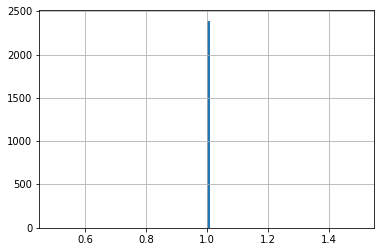

In [25]:
(final_df['prediction_fvg_prob_no'] - final_df['prediction_fvg_prob_yes']).hist(bins=100)

#### Minority Class (yes) Distribution
We're interested in "yes" cases here because it's easy to find "no" cases. <br>
Priority is to make sure our classifier can find "yes" cases (whether or not they are in majority in coded data).

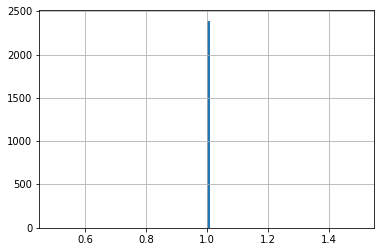

In [26]:
final_df['prediction_fvg_prob_no'].hist(bins=100)

In [27]:
threshold = calculate_threshold(225, final_df['prediction_fvg_prob_yes'])
num = len(final_df[final_df['prediction_fvg_prob_yes'] > threshold])
prop = (num/len(final_df))*100
print(f'{str(round(prop,3))}% ({num}) of cases are above {str(threshold)}')

100.0% (2390) of cases are above -0.001


## Select tweets for sample

Get sample of new tweets composed of 90% minority class and 10% majority class.<br>
To improve fidelity of model, make the tweets selected majority class fuzzy/unreliable, so model gets better at labeling these.<br>
First, filter into new DFs, one for minority class and one for (fuzzy) majority class.

In [31]:
# set thresholds for minority cases for each myth
# set these as low as possible to capture ~140 tweets likely to fall in minority class
capture_num = 162

minority_threshold_fvg = calculate_threshold(capture_num,final_df['prediction_fvg_prob_yes'])

# filter using threshold
df_fvg_minority = final_df[final_df['prediction_fvg_prob_yes'] > minority_threshold_fvg]

# check out results
print('Number of minority cases selected for each myth:')

print(f'{len(df_fvg_minority)} for 5G')

Number of minority cases selected for each myth:
2390 for 5G


In [32]:
def check_pred_fuzzy(row, 
                     pred_labels = ['yes', 'no'], 
                     myth_labels = ['fvg','msq'],
                     upper_threshold=0.3, 
                     lower_threshold=0.10):
    
    '''
    Checks whether prediction is fuzzy/unreliable. Use this to determine if a tweet is worth hand-coding.
    Rationale: by only coding tweets with unreliable labels, we can improve the classifier's ability to detect 'unsure' cases.
    
    Function focuses on this difference: prob(predicted label) - prob(some other label).
    If difference is greater than lower_threshold (minimum for hand-coding of tweet to be possible), 
    but lesser than upper_threshold (maximum for hand-coding to be necessary), then it IS worth coding, so return True. 
    If difference is not between these, then we either it can't be reliably coded, or already have a reliable prediction,
    so we don't need to hand-code --> return False.

    To help select a threshold, ask: To what extent do we want the uncertainty to be, to help inform our sample selection?    
    For example, if a tweet is labeled as POS with 90% prob and NEG 10% --> this is very obvious sample, so don't bother coding.
    On the other hand, if the predictions are 51% NEG and 49 POS, then we need ppl to label this to update our model. 
    If our upper_threshold is 20% (0.20), then if a tweet has 61% NEG 39% POS probabilities, we don't choose it. 
    If some other tweet has prob 59% POS 41% NEG, we do select it for coding.
    
    Args:
        row: row corresponding to tweet, with predictions in format...
        pred_labels: labels for probabilities to use--used for naming columns
        myth_labels: labels for COVID-19 myths to detect--used for naming columns
        upper_threshold: max difference between predicted probs
        lower_threshold: min difference between predicted probs
    
    Returns:
        Array: True if tweet should be hand-coded, otherwise False. Array contains determinations for all myths
    '''
    
    worth_coding = []
    
    for myth in myth_labels:
        pred_label = row[f'prediction_{myth}'].strip() # get label of prediction for tweet--must be one of those in possible_labels!
        pred_score = float(row[f'prediction_{myth}_prob_{pred_label}']) # get probability of predicted label (probably high)
        
        for pred in pred_labels: # Look at each label
            pred = pred.strip() # clean label text
            
            if pred != pred_label: # if this label isn't the predicted one...
                difference = pred_score - float(row[f'prediction_{myth}_prob_{pred}']) # ...then look at their difference in probability
                if lower_threshold <= difference <= upper_threshold:
                 # if difference in probs is > lower_threshold but < upper_threshold, then pred is fuzzy and we should code
                    worth_coding.append(True) # worth coding
                
                else: worth_coding.append(False)
                    
    if len(worth_coding) == 1:
        return worth_coding[0]
    
    else: return worth_coding

In [33]:
df_fvg_fuzzy = final_df[final_df.progress_apply(lambda x: check_pred_fuzzy(x, myth_labels = ['fvg'], upper_threshold = .65), axis=1)]

print(f'df_fvg_fuzzy: {df_fvg_fuzzy.shape}')

100%|██████████| 2390/2390 [00:00<00:00, 44024.53it/s]

df_fvg_fuzzy: (0, 7)


## Compile sample

In [34]:
def sample_tweets(df, df_minority, df_fuzzy, sample_size=150, prop_maj=.1):
    '''
    Preliminary script to sample tweets using the previously determined minority and fuzzy df.
    Does not take into account distribution of dates.
    
    Args:
        df: original df with tweet id and full text
        df_minority: minority df with tweets above threshold
        sample_size: number of total tweets to sample
        prop_maj: proportion of total tweets to be majority label/fuzzy
        
    '''
    df_sample = pd.DataFrame()
    min_size = int(sample_size * (1-prop_maj))
    maj_size = sample_size - min_size
    
    for id in tqdm(df_minority['id'].sample(n=min_size)):
        df_sample = df_sample.append(df.loc[df['id'] == id][['id','created_at','full_text']],ignore_index=True)
    for id in tqdm(df_fuzzy['id'].sample(n=maj_size)):
        df_sample = df_sample.append(df.loc[df['id'] == id][['id','created_at','full_text']],ignore_index=True)
    df_sample = df_sample.sample(frac=1).reset_index(drop=True)
    return df_sample

fvg_sample = sample_tweets(final_df,df_fvg_minority, df_fvg_fuzzy, sample_size = n_sample)
print(fvg_sample.head(5))

100%|██████████| 18/18 [00:00<00:00, 312.15it/s]

                    id                created_at  \
0  1248270465996472322 2020-04-09 15:24:05+00:00   
1  1266301741517041666 2020-05-29 09:33:56+00:00   
2  1386102185084157952 2021-04-24 23:38:08+00:00   
3  1391394701950005251 2021-05-09 14:08:42+00:00   
4  1248076153606115329 2020-04-09 02:31:57+00:00   

                                           full_text  
0  @RepTedBudd #WuhanCoronaVirus is a big lesson....  
1  This is what the plan was..spread coronavirus ...  
2  New article: COVID-19 study found that 0.4% of...  
3  #Wuhan originated #COVID19 virus was infact ma...  
4  🚨Impeachment Articles delivered The Same Day t...  


### Check date distribution and remove column

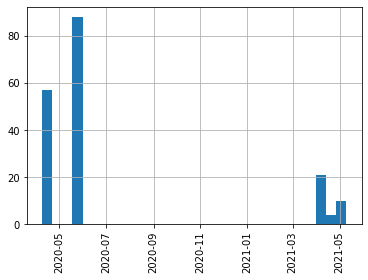

In [38]:
fvg_sample['created_at'].hist(bins = 30, xrot = 90)
fvg_sample.drop(columns = 'created_at', inplace = True)

## Save to file

In [42]:
fvg_sample.to_csv(fvg_sam_fp,\
    escapechar='\"', \
    quotechar='\"',\
    quoting=csv.QUOTE_ALL,\
    index=False)